# Demo for the DoWhy causal API
We show a simple example of adding a causal extension to any dataframe. 

In [1]:
import dowhy.datasets
import dowhy.api
from dowhy.graph import build_graph_from_str

import numpy as np
import pandas as pd

from statsmodels.api import OLS

In [2]:
data = dowhy.datasets.linear_dataset(beta=5,
        num_common_causes=1,
        num_instruments = 0,
        num_samples=1000,
        treatment_is_binary=True)
df = data['df']
df['y'] = df['y'] + np.random.normal(size=len(df)) # Adding noise to data. Without noise, the variance in Y|X, Z is zero, and mcmc fails.
nx_graph = build_graph_from_str(data["dot_graph"])

treatment= data["treatment_name"][0]
outcome = data["outcome_name"][0]
common_cause = data["common_causes_names"][0]
df

,W0,v0,y
0,-1.548757,False,-4.125338
1,0.606056,True,7.335386
2,-0.068433,True,7.087289
3,0.915575,False,0.609888
4,1.057662,True,6.396257
...,...,...,...
995,0.899284,True,6.771494
996,0.578275,True,6.951933
997,0.791586,True,8.575460
998,0.603457,False,1.577286


<Axes: xlabel='v0'>

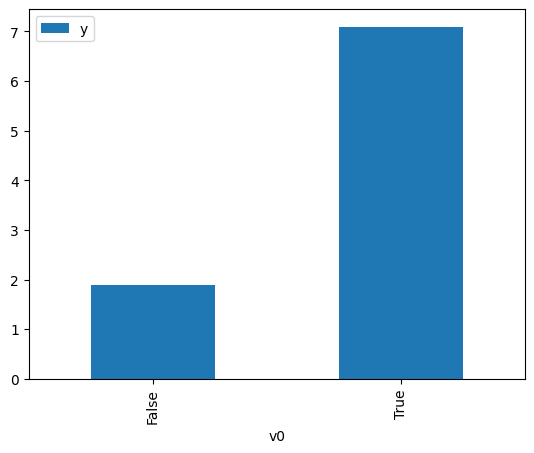

In [3]:
# data['df'] is just a regular pandas.DataFrame
df.causal.do(x=treatment,
             variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'},
             outcome=outcome,
             common_causes=[common_cause],
            ).groupby(treatment).mean().plot(y=outcome, kind='bar')

<Axes: xlabel='v0'>

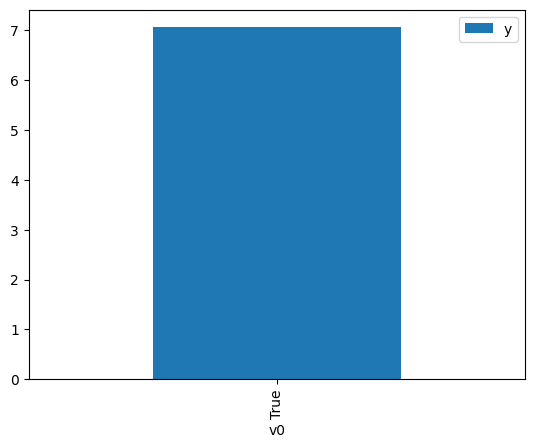

In [4]:
df.causal.do(x={treatment: 1}, 
              variable_types={treatment:'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome,
              method='weighting', 
              common_causes=[common_cause]
              ).groupby(treatment).mean().plot(y=outcome, kind='bar')

In [5]:
cdf_1 = df.causal.do(x={treatment: 1}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              graph=nx_graph
              )

cdf_0 = df.causal.do(x={treatment: 0}, 
              variable_types={treatment: 'b', outcome: 'c', common_cause: 'c'}, 
              outcome=outcome, 
              graph=nx_graph
              )


In [6]:
cdf_0

,W0,v0,y,propensity_score,weight
0,1.548809,False,3.089482,0.466384,2.144157
1,1.768882,False,5.429025,0.465044,2.150333
2,0.795293,False,1.709966,0.470973,2.123262
3,0.433214,False,1.420479,0.473181,2.113358
4,0.636328,False,2.849297,0.471942,2.118903
...,...,...,...,...,...
995,-0.781142,False,-2.654179,0.480591,2.080774
996,1.349915,False,1.480500,0.467595,2.138604
997,1.365777,False,3.349460,0.467498,2.139046
998,1.105184,False,4.144365,0.469085,2.131809


In [7]:
cdf_1

,W0,v0,y,propensity_score,weight
0,3.019176,True,11.837683,0.542555,1.843130
1,-1.315945,True,0.622733,0.516143,1.937446
2,2.025660,True,10.818434,0.536518,1.863871
3,-0.500374,True,4.745536,0.521124,1.918931
4,0.420915,True,6.872575,0.526744,1.898454
...,...,...,...,...,...
995,-0.180589,True,3.420235,0.523075,1.911771
996,-0.380616,True,3.197561,0.521855,1.916243
997,-0.857161,True,2.550775,0.518945,1.926985
998,-0.802851,True,3.063087,0.519277,1.925755


## Comparing the estimate to Linear Regression
First, estimating the effect using the causal data frame, and the 95% confidence interval.

In [8]:
(cdf_1['y'] - cdf_0['y']).mean()

In [9]:
1.96*(cdf_1['y'] - cdf_0['y']).std() / np.sqrt(len(df))

Comparing to the estimate from OLS.

In [10]:
model = OLS(np.asarray(df[outcome]), np.asarray(df[[common_cause, treatment]], dtype=np.float64))
result = model.fit()
result.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                                 OLS Regression Results                                
=======================================================================================
Dep. Variable:                      y   R-squared (uncentered):                   0.971
Model:                            OLS   Adj. R-squared (uncentered):              0.971
Method:                 Least Squares   F-statistic:                          1.665e+04
Date:                Wed, 09 Oct 2024   Prob (F-statistic):                        0.00
Time:                        16:25:45   Log-Likelihood:                         -1437.1
No. Observations:                1000   AIC:                                      2878.
Df Residuals:                     998   BIC:                                      2888.
Df Model:                           2                                                  
Covariance Type:            nonrobust                                                  
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
x1             2.4769      0.028     86.996      0.000       2.421       2.533
x2             5.1196      0.050    102.655      0.000       5.022       5.217
==============================================================================
Omnibus:                        0.195   Durbin-Watson:                   2.035
Prob(Omnibus):                  0.907   Jarque-Bera (JB):                0.258
Skew:                           0.026   Prob(JB):                        0.879
Kurtosis:                       2.941   Cond. No.                         2.15
==============================================================================

Notes:
[1] R² is computed without centering (uncentered) since the model does not contain a constant.
[2] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""